# Introducción

Una compañía de Taxis ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. 

Se debe construir un modelo para dicha predicción. La métrica de evaluación es la RECM cuyo valor en el conjunto de prueba no debe ser superior a 48.

In [1]:
# Cargar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [2]:
# Importar la base de datos
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
# Observar primeras columnas de la tabla
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
# Dimensiones de la tabla
df.shape

(26496, 2)

In [5]:
# Presencia de valores ausentes
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [6]:
# Tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
# La columna date time tiene orden cronológico?
df['datetime'].is_monotonic

True

In [8]:
# Temporalidad de los datos
df['datetime'].max(), df['datetime'].min()

('2018-08-31 23:50:00', '2018-03-01 00:00:00')

In [9]:
# Observar la distribución básica de los datos
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


**Observaciones iniciales:**
- Tenemos un marco de datos de solo dos columnas, es una serie de tiempo con sólo una variable.
- La columna de `datetime` podría ser transformada en su índice.
- `datetime` puede ser transformada al formato datetime de donde es posible extrar más características.
- No hay valores ausentes.
- Los datos van desde el primero de marzo del 2018 hasta el 31 de agosto de 2018.
- No hay valores imposibles como un número de entregar por unidad de tiempo negativas.


In [10]:
# Podemos cargar nuevamente los datos modificanco eficientemente algunas de sus propiedades.
df = pd.read_csv('/datasets/taxi.csv', index_col = ['datetime'], parse_dates = ['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
# Comprobar que los datos estén ordenados cronológicamente
df.index.is_monotonic

True

In [12]:
# Temporalidad de los datos
df.head(1), df.tail(1)

(            num_orders
 datetime              
 2018-03-01           9,
                      num_orders
 datetime                       
 2018-08-31 23:50:00          53)

## Remuestreo y análisis

Dado que la compañía busca predecir los valores cada hora debemos hacer un remuestreo por el mismo periodo.

In [13]:
# Obtener todos los pedidos recibidos cada hora.
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
# Nuevas dimensiones de nuestra tabla
df.shape

(4416, 1)

Las 26496 filas que teníamos previamente se conviertieron en tan solo 4416 sin perder cada uno de los pedidos hechos. NO obstante, al graficar los valores aún tenemos suficientes datos en nuestra serie de tiempo.

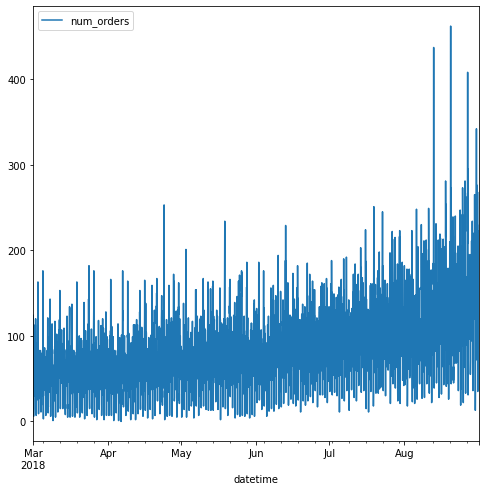

In [15]:
# Mostrar los valores de las entregas a lo largo del tiempo.
df.plot(figsize=(8,8));

Para observarlos desde otra perspectiva podemos separar sus componentes tendenciales, estacionales y residuales.

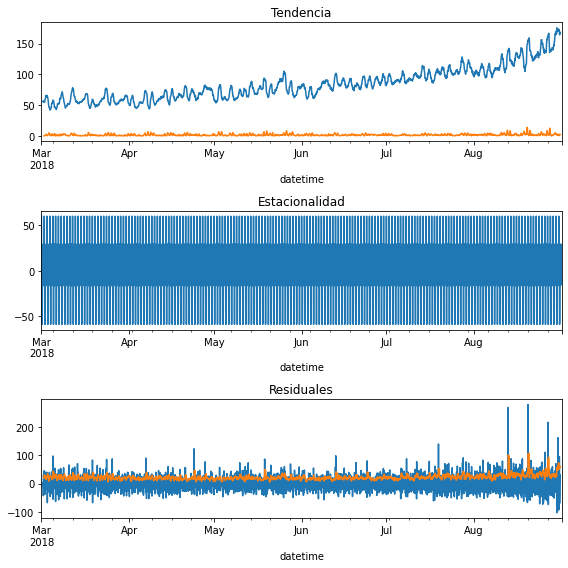

In [16]:
# Observar sus componentes tendenciales, estacionales y de ruido.

# Crear instancia
decomposed = seasonal_decompose(df)

# Graficar cada uno de sus componentes
plt.figure(figsize = (8,8) )

# Componente tendencial
plt.subplot(311)
decomposed.trend.plot(ax = plt.gca())
decomposed.trend.rolling(10).std().plot(ax = plt.gca())
plt.title('Tendencia')

plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Estacionalidad')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
decomposed.resid.rolling(10).std().plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()


Se observa que la tendencia es ascendendente para el conjunto de datos. No obstante, la estacionalidad es inobservable, en parte porque el periodo de tiempo no muestra suficientes elementos de ascenso y descenso que se puedan tomar como estacionalidad. En efecto, la varianza móvil tanto de la tendencia como de los valores residuales es relativamente constante o se encuentra dentro de un rango relativamente reducido.

## Obtención de características para el entrenamiento del modelo

Posteriormente, para entrenar nuestro modelo debemos darle valores que pueda interpretar como variables. Cada una de las características se puede extraer de nuestro índice. Las características que podemos extraer son:

- Características de calendario, exceptuando año, pues tenemos un periodo menor a un año.
- Desfaces de tiempo.
- Medias móviles. 

Crear una función facilitará la extraccion de cada uno de estos elementos.

In [17]:
# función para obtener todas las caracteristicas para entrenar nuestro modelos.
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['lag_1'].rolling(rolling_mean_size).mean()

make_features(df, 3, 5)

In [18]:
# Nuevo marco de datos creado
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,NaN


Por la naturaleza de la extracción de los datos es imposible obtener todos los valores para las primeras filas del marco de datos. No obstante, podemos eliminar estas filas ya que se trata de un número muy reducido de valores perdidos en comparación con los obtenidos.

In [19]:
# Eliminar las filas que tengan valores ausentes
df.dropna(inplace = True)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,,,
2018-03-01 05:00:00,6,3,1,3,5,43.0,66.0,71.0,77.8
2018-03-01 06:00:00,12,3,1,3,6,6.0,43.0,66.0,54.2
2018-03-01 07:00:00,15,3,1,3,7,12.0,6.0,43.0,39.6
2018-03-01 08:00:00,34,3,1,3,8,15.0,12.0,6.0,28.4
2018-03-01 09:00:00,69,3,1,3,9,34.0,15.0,12.0,22.0


## Obtención de los conjuntos de entrenamiento y prueba

In [20]:
# Crear conjunto de entrenamiento y de prueba
train, test = train_test_split(df, shuffle = False, test_size = 0.1)

# Separar características de los objetivos
x_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']

x_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

## Modelos

Como prueba de cordura el primer modelo predecirá simplemente tomando la mediana como el valor con el cual predecir por cada unidad de tiempo.

### Prueba de cordura

In [21]:
# Modelo de cordura
sanity_omens = np.ones(len(y_test)) * y_train.median()
sanity_rmse = mean_squared_error(y_test, sanity_omens, squared = False)
sanity_rmse

87.15277582981295

### Modelo de regresión lineal

In [22]:
# Modelo de regresión lineal
linear = LinearRegression()
# Entrenar el modelo
model = linear.fit(x_train, y_train)
# Predecir con el modelo
linear_omens = model.predict(x_test)
# Calcular RECM de la predicción
linear_rmse = mean_squared_error(y_test, linear_omens, squared = False)
#Resultado
linear_rmse

52.73155022715022

### Modelo Ridge

In [23]:
ridge = Ridge(random_state = 24601)

hip_ridge = {'alpha': [.1, .5, 1, 2,5,10], 'fit_intercept': [True, False]}

gs_ridge = GridSearchCV(estimator =ridge, param_grid = hip_ridge, scoring = 'neg_root_mean_squared_error', cv = 2)

best_ridge = gs_ridge.fit(x_train, y_train)

best_ridge.best_params_

{'alpha': 10, 'fit_intercept': False}

In [24]:
# Evaluar el modelo
# predecir con el mejor modelo
ridge_omens = best_ridge.predict(x_test)
# evaluar su prediccion
ridge_rmse = mean_squared_error(y_test, ridge_omens, squared = False)
# Ver resultado
ridge_rmse

52.22890526655646

### Modelo de bosque aleatorio

In [25]:

# Crear instancia de la grilla
# Instancia de bosque aleatorio
bosque = RandomForestRegressor(random_state = 24601)

hip_bosque = {'n_estimators': [2,3,5,10,15,20,30], 'max_depth': [2,3,4,5,6,10,12,14]}

gs_bosque = GridSearchCV(estimator = bosque, param_grid = hip_bosque, scoring = 'neg_root_mean_squared_error', cv = 2)

best_bosque = gs_bosque.fit(x_train, y_train)

best_bosque.best_params_


{'max_depth': 14, 'n_estimators': 20}

In [26]:

# predecir con el mejor modelo
bosque_omens = best_bosque.predict(x_test)
# evaluar su prediccion
bosque_rmse = mean_squared_error(y_test, bosque_omens, squared = False)
# Ver resultado
bosque_rmse


48.81389569489988

### Modelo basado en el descenso del gradiente

In [27]:
# Convertir los datos a formato LightGBM
train_data = lgb.Dataset(x_train, label = y_train)
test_data = lgb.Dataset(x_test, label = y_test)

# Establecer los parámetros

params = {
    'objective':'regression',
    'learning_rate':0.4,
    'num_leaves': 15
}
# entrenar el modelo
gbm = lgb.train(params,train_data, num_boost_round = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 895
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 8
[LightGBM] [Info] Start training from score 78.291257


In [28]:
# Hacer predicciones
gbm_omens = np.round(gbm.predict(x_test))
# Evaluar el modelo
gbm_rmse = mean_squared_error(y_test, gbm_omens, squared = False)
gbm_rmse

43.72991458789113

## Resumen de los resultados

In [29]:
valores = ([sanity_rmse],
    [linear_rmse],
           [ridge_rmse],
           [bosque_rmse], 
           [gbm_rmse])

resumen = pd.DataFrame(data=valores, index = ['Prueba de cordura', 'Regresión Lineal','Ridge','Bosque Aleatorio','LightGBM'], columns = ['RMSE'])
resumen

,RMSE
Prueba de cordura,87.152776
Regresión Lineal,52.731550
Ridge,52.228905
Bosque Aleatorio,48.813896
LightGBM,43.729915


Como se muestra en la tabla, la prueba de cordura estableció un máximo desde el cuál comparar nuestros datos. En este caso, la regresión lineal estuvo cerca de alcanzar el valor mínimo de 48 puntos, no obstante, aún aplicando el modelo Ridge, su valor no bajo mucho. La mejora la encontramos con el Bosque Aleatorio que alcanza un valor muy cercano al requerido. No obstante, el modelo de lightGBM sí logró estar, y bastante por debajo, del valor máximo de 48 puntos para nuestra métrica.

## Conclusión

El marco de datos inicial sólo contenía dos columnas. Una que tenía valores temporales y la otra con la cantidad de entregas. Los datos estaban limpios y completos. De la primera columna se extrajeron valores de calendario, además se aplicaron 3 rezagos en los datos y una media movil de cada 5 horas. Adicionalmente, se observó que los datos tenían una tendencia alcista con varianza relativamente estable, lo que describía unos datos relativamente estacionarios. 

Para los modelos, primero se aplicó un modelo simple que sirviera coo prueba de cordura y se partió desde ese valor para ser mejorado. Se fueron aplicando modelos cada vez más complejos para no superar el valor máximo aceptable de la métrica conocida como la raíz cuadrada del error cuadrático medio. El modelo basado en el descenso del gradiente alcanzó una RMSE de 43.72, muy por debajo del 48 máximo aceptable. 